<a href="https://colab.research.google.com/github/Visa110804/Time-series-forecasting/blob/main/Time_series_forrecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Upload CSV file to Colab
from google.colab import files
uploaded = files.upload()


Saving Weather_Data.csv to Weather_Data.csv


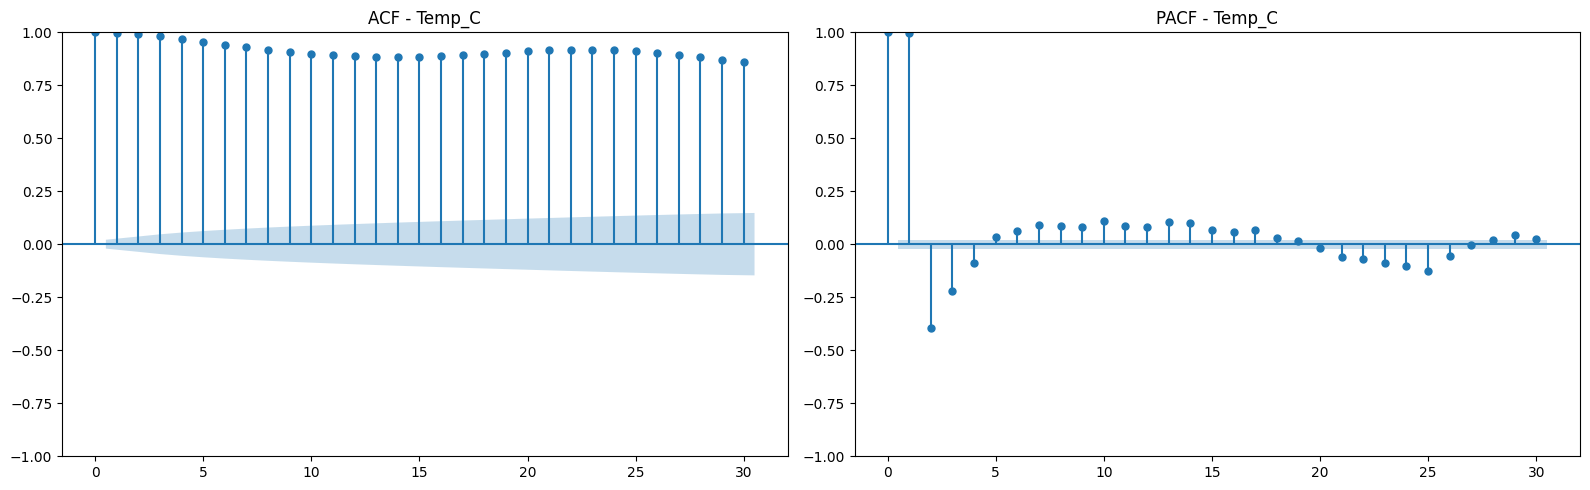

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load your dataset (replace with your actual file path)
df = pd.read_csv('Weather_Data.csv')

# Ensure Date/Time is parsed correctly
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)

# Optionally, resample to daily if your data is hourly
# df = df.resample('D').mean()

# Drop missing values
df = df.dropna()

# Choose the target variable
target_variable = 'Temp_C'

# Plot ACF and PACF for Temp_C
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df[target_variable], lags=30, ax=axes[0])
axes[0].set_title('ACF - Temp_C')

plot_pacf(df[target_variable], lags=30, ax=axes[1], method='ywm')  # use method='ywm' to avoid warnings
axes[1].set_title('PACF - Temp_C')

plt.tight_layout()
plt.show()


Seasonal ACF values for Temp_C at lags [24, 48]: [np.float64(0.9172725169644889), np.float64(0.8660068365185649)]
Seasonal PACF values for Temp_C at lags [24, 48]: [np.float64(-0.1037141966903706), np.float64(-0.07346944713320891)]


/tmp/ipython-input-1137423162.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


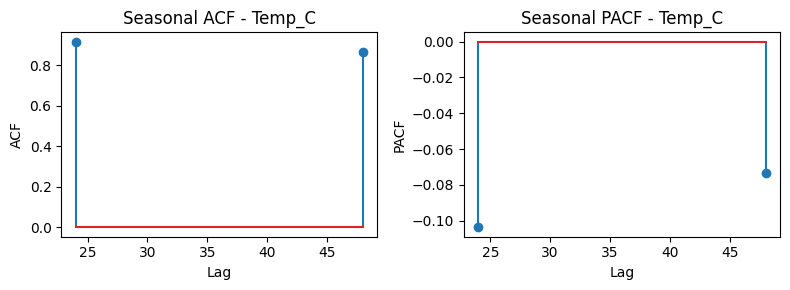

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf

# Load dataset and prepare
df = pd.read_csv('Weather_Data.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)
df = df.fillna(method='ffill')

seasonal_lags = [24, 48]
col = 'Temp_C'

# Calculate seasonal ACF values at specified lags
seasonal_acf_vals = [df[col].autocorr(lag=lag) for lag in seasonal_lags]

# Calculate full PACF and extract seasonal lags
pacf_vals = pacf(df[col], nlags=max(seasonal_lags), method='ywm')
seasonal_pacf_vals = [pacf_vals[lag] for lag in seasonal_lags]

# Print values
print(f"Seasonal ACF values for {col} at lags {seasonal_lags}: {seasonal_acf_vals}")
print(f"Seasonal PACF values for {col} at lags {seasonal_lags}: {seasonal_pacf_vals}")

# Plot seasonal ACF and PACF
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.stem(seasonal_lags, seasonal_acf_vals)
plt.title(f'Seasonal ACF - {col}')
plt.xlabel('Lag')
plt.ylabel('ACF')

plt.subplot(1,2,2)
plt.stem(seasonal_lags, seasonal_pacf_vals)
plt.title(f'Seasonal PACF - {col}')
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()


/tmp/ipython-input-2738243032.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


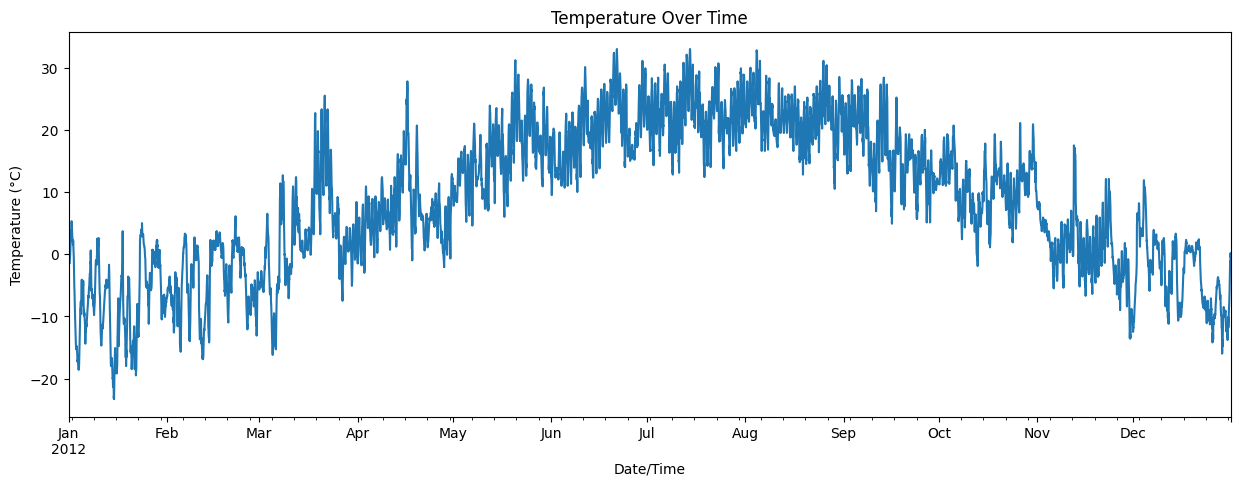

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-2738243032.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(predictions.index[-1], predictions[-1], 'ro', label='Next Hour Forecast')


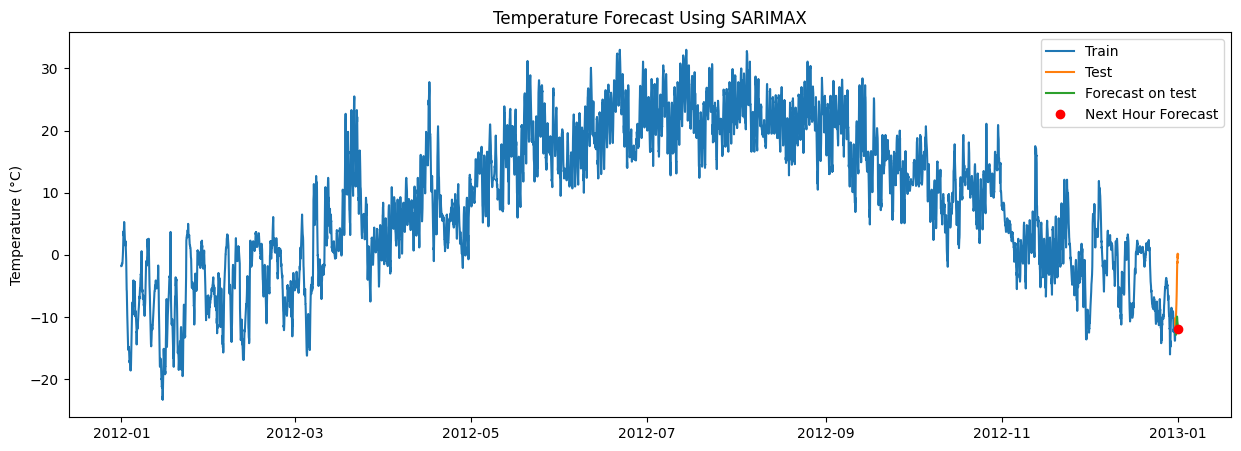

Test RMSE: 6.96
Predicted temperature for the next hour (2013-01-01 00:00:00): -11.98 °C


/tmp/ipython-input-2738243032.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Predicted temperature for the next hour ({predictions.index[-1]}): {predictions[-1]:.2f} °C")


In [2]:
# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

# Step 3: Load the uploaded CSV file
df = pd.read_csv('Weather_Data.csv')

# Step 4: Convert datetime column and set as index
if 'Date/Time' in df.columns:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
    df.set_index('Date/Time', inplace=True)
else:
    print(" The dataset doesn't include a 'Date/Time' column.")
    # Optional: create a fake datetime index for testing
    df.index = pd.date_range(start='2023-01-01', periods=len(df), freq='H')
    print(" A synthetic hourly datetime index was created.")

# Step 5: Handle missing values
df = df.fillna(method='ffill')

# Step 6: Use the correct temperature column
temperature = df['Temp_C']

# Step 7: Visualize the temperature data
temperature.plot(figsize=(15,5), title='Temperature Over Time')
plt.ylabel('Temperature (°C)')
plt.show()

# Step 8: Split into train and test sets (last 24 hours for testing)
train = temperature[:-24]
test = temperature[-24:]

# Step 9: Fit SARIMAX model
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24))
model_fit = model.fit(disp=False)

# Step 10: Predict for test set + 1 hour ahead
start = len(train)
end = start + len(test)  # up to last test hour
predictions = model_fit.predict(start=start, end=end)

# Step 11: Plot actual vs predicted
plt.figure(figsize=(15,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(predictions.index[:-1], predictions[:-1], label='Forecast on test')
plt.plot(predictions.index[-1], predictions[-1], 'ro', label='Next Hour Forecast')
plt.legend()
plt.title('Temperature Forecast Using SARIMAX')
plt.ylabel('Temperature (°C)')
plt.show()

# Step 12: Evaluate model
test_rmse = rmse(test, predictions[:-1])
print(f'Test RMSE: {test_rmse:.2f}')

# Step 13: Show next hour forecast
print(f"Predicted temperature for the next hour ({predictions.index[-1]}): {predictions[-1]:.2f} °C")


In [3]:
print(df.columns.tolist())



['Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h', 'Visibility_km', 'Press_kPa', 'Weather']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load your dataset (already uploaded as Weather_Data.csv)
df = pd.read_csv('Weather_Data.csv')

# Parse datetime and set index
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)

# Forward-fill missing values
df = df.fillna(method='ffill')

# Extract temperature series
temperature = df['Temp_C']

# Check if target prediction time exists
target_time = pd.Timestamp('2013-01-01 01:00:00')
if target_time not in temperature.index:
    print(f"Target time {target_time} not in dataset.")
else:
    print(f"Target time {target_time} exists in dataset.")

# Use data up to just before target time for training
train = temperature.loc[:target_time - pd.Timedelta(hours=1)]

# Fit SARIMAX model (basic seasonal config, can be tuned)
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24))
model_fit = model.fit(disp=False)

# Forecast up to the target time
pred = model_fit.predict(start=target_time, end=target_time)

# Display the predicted temperature
print(f"🌡️ Predicted temperature at {target_time}: {pred.iloc[0]:.2f} °C")


Target time 2013-01-01 01:00:00 not in dataset.


/tmp/ipython-input-3872750961.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


🌡️ Predicted temperature at 2013-01-01 01:00:00: -0.29 °C


In [10]:
pip install pmdarima pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.8 MB/s eta 0:00:00


In [11]:
pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 38.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.

In [12]:
pip uninstall -y pmdarima

Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4


In [ ]:
pip install pmdarima

  Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.3 MB)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 179, in resolve
    self.factory.preparer.prepare_linked_requirements_more(reqs)
 

In [1]:
!pip uninstall -y numpy pmdarima



Found existing installation: numpy 2.3.2
Uninstalling numpy-2.3.2:
  Successfully uninstalled numpy-2.3.2


In [2]:
!pip install numpy==1.23.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 46.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [3]:
!pip uninstall -y numpy pmdarima


In [4]:
!pip install numpy==1.23.5 --only-binary=:all:


ERROR: Could not find a version that satisfies the requirement numpy==1.23.5 (from versions: 1.26.0, 1.26.1, 1.26.2, 1.26.3, 1.26.4, 2.0.0, 2.0.1, 2.0.2, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.2.6, 2.3.0, 2.3.1, 2.3.2)
ERROR: No matching distribution found for numpy==1.23.5


In [5]:
import numpy as np
print(np.__version__)


2.3.2


In [6]:
!pip uninstall -y numpy



In [7]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 35.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


                     Temp_C  Dew Point Temp_C  Rel Hum_%  Wind Speed_km/h  \
Date/Time                                                                   
2012-01-01 00:00:00    -1.8              -3.9         86                4   
2012-01-01 01:00:00    -1.8              -3.7         87                4   
2012-01-01 02:00:00    -1.8              -3.4         89                7   
2012-01-01 03:00:00    -1.5              -3.2         88                6   
2012-01-01 04:00:00    -1.5              -3.3         88                7   

                     Visibility_km  Press_kPa               Weather  
Date/Time                                                            
2012-01-01 00:00:00            8.0     101.24                   Fog  
2012-01-01 01:00:00            8.0     101.24                   Fog  
2012-01-01 02:00:00            4.0     101.26  Freezing Drizzle,Fog  
2012-01-01 03:00:00            4.0     101.27  Freezing Drizzle,Fog  
2012-01-01 04:00:00            4.8     1

/tmp/ipython-input-3067628951.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/py

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25488.137, Time=0.20 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23974.311, Time=0.53 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24474.098, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25486.138, Time=0.19 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23543.734, Time=1.43 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23487.177, Time=2.09 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=23471.015, Time=3.62 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=23422.911, Time=2.90 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=22899.191, Time=18.56 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=22958.011, Time=16.58 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=22953.041, Time=33.20 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=22747.888, Time=30.00 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=23.79 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=31.77 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23481.742, Time=4.86 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=22420.248, Time=28.56 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=26.38 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=33.56 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22417.979, Time=20.40 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23479.355, Time=2.83 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23510.313, Time=6.84 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23574.958, Time=3.14 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23427.320, Time=4.50 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=22415.979, Time=9.08 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=23477.355, Time=1.35 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=23508.313, Time=1.43 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=11.46 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=12.33 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23572.958, Time=1.11 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=23425.320, Time=2.08 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=23479.742, Time=2.28 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=22417.155, Time=12.08 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 350.623 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8784
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -11202.990
Date:                Mon, 01 Sep 2025   AIC                          22415.979
Time:                        04:27:05   BIC                          22451.382
Sample:                    01-01-2012   HQIC                         22428.041
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9302      0.001   2940.669      0.000       1.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


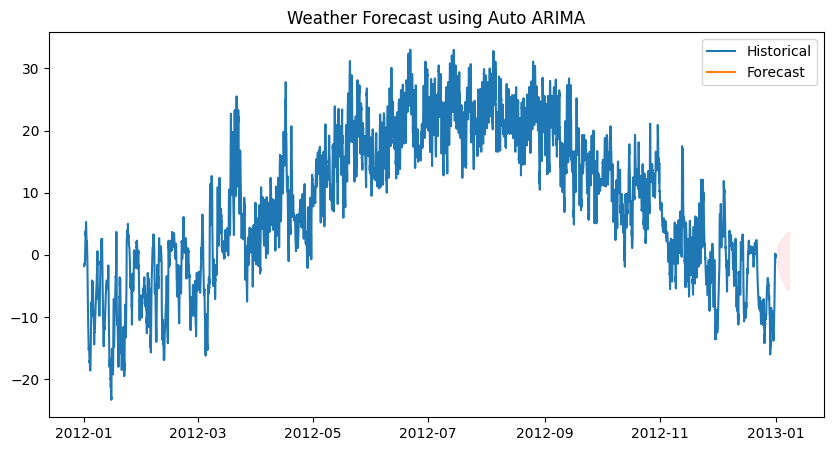

In [1]:
# Install pmdarima if not installed
!pip install pmdarima --quiet

import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt

# Example: Load your weather data CSV
# Replace 'weather_data.csv' with your actual file path
# Assume CSV has columns: 'date', 'temperature' (or any weather variable)
df = pd.read_csv('Weather_Data.csv', parse_dates=['Date/Time'], index_col='Date/Time')

# Inspect your data
print(df.head())

# Choose the column you want to forecast, e.g. 'temperature'
ts = df['Temp_C']

# Optional: Check for missing values and handle them
ts = ts.fillna(method='ffill')

# Fit auto_arima model
model = pm.auto_arima(ts,
                      start_p=0, start_q=0,
                      max_p=5, max_q=5,
                      seasonal=False,      # Set True if your data is seasonal
                      stepwise=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

print(model.summary())

# Forecast the next n steps (e.g., next 7 days)
n_forecast = 7
forecast, conf_int = model.predict(n_periods=n_forecast, return_conf_int=True)

# Create forecast index (dates)
last_date = ts.index[-1]
forecast_index = pd.date_range(last_date, periods=n_forecast+1, freq='D')[1:]

# Convert forecast to pandas Series
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(ts, label='Historical')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('Weather Forecast using Auto ARIMA')
plt.legend()
plt.show()


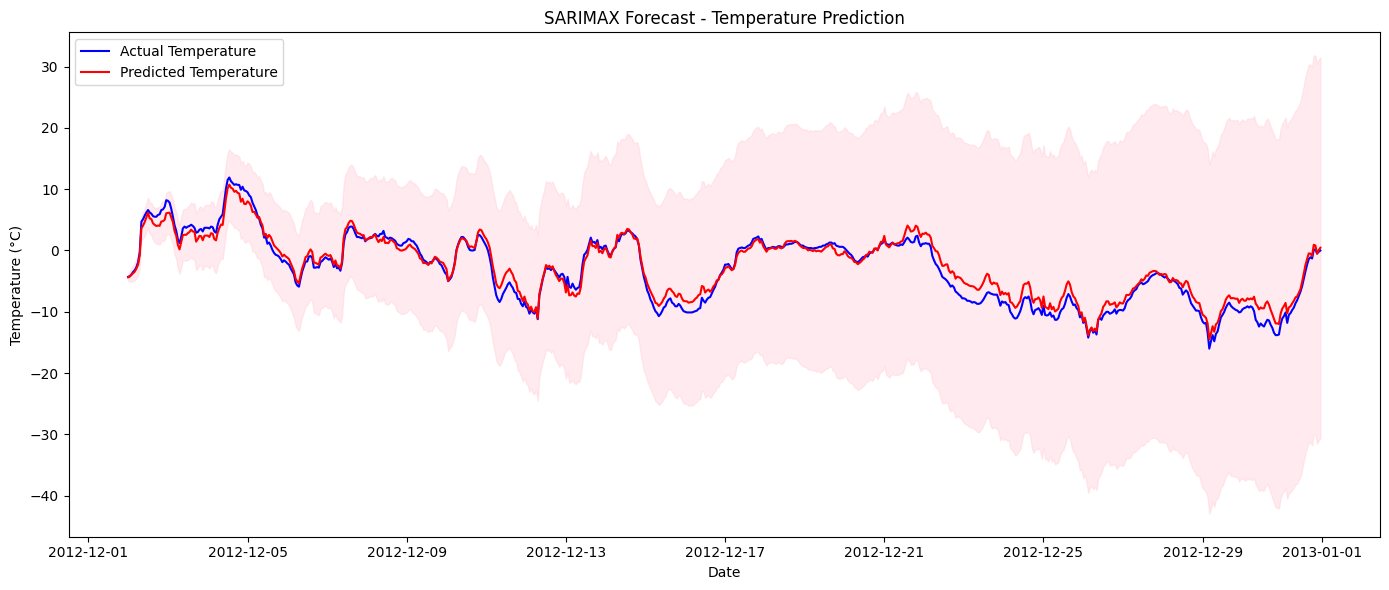

Test RMSE: 1.25 °C


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 1. Load your dataset
df = pd.read_csv('Weather_Data.csv')  # Replace with your file path

# 2. Ensure 'Date/Time' column exists
if 'Date/Time' in df.columns:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
else:
    df['Date/Time'] = pd.date_range(start='2024-01-01', periods=len(df), freq='H')

df.set_index('Date/Time', inplace=True)

# 3. Handle missing values
df.fillna(method='ffill', inplace=True)

# 4. Encode 'Weather' column
le = LabelEncoder()
df['Weather_encoded'] = le.fit_transform(df['Weather'])

# 5. Define target and exogenous variables
target = 'Temp_C'
exog_vars = ['Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h',
             'Visibility_km', 'Press_kPa', 'Weather_encoded']

y = df[target]
exog = df[exog_vars]

# 6. Train/Test Split
# We'll forecast the last 30 days (you can change this)
forecast_horizon = 24 * 30  # 30 days of hourly data
y_train, y_test = y[:-forecast_horizon], y[-forecast_horizon:]
exog_train, exog_test = exog[:-forecast_horizon], exog[-forecast_horizon:]

# 7. Fit SARIMAX model
model = SARIMAX(y_train,
                exog=exog_train,
                order=(1, 1, 1),         # You can tune this
                seasonal_order=(1, 1, 1, 24),  # 24-hour seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# 8. Forecast
pred = results.get_forecast(steps=forecast_horizon, exog=exog_test)
y_pred = pred.predicted_mean
conf_int = pred.conf_int()

# 9. Plot results
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual Temperature', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Temperature', color='red')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast - Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()

# 10. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f} °C")


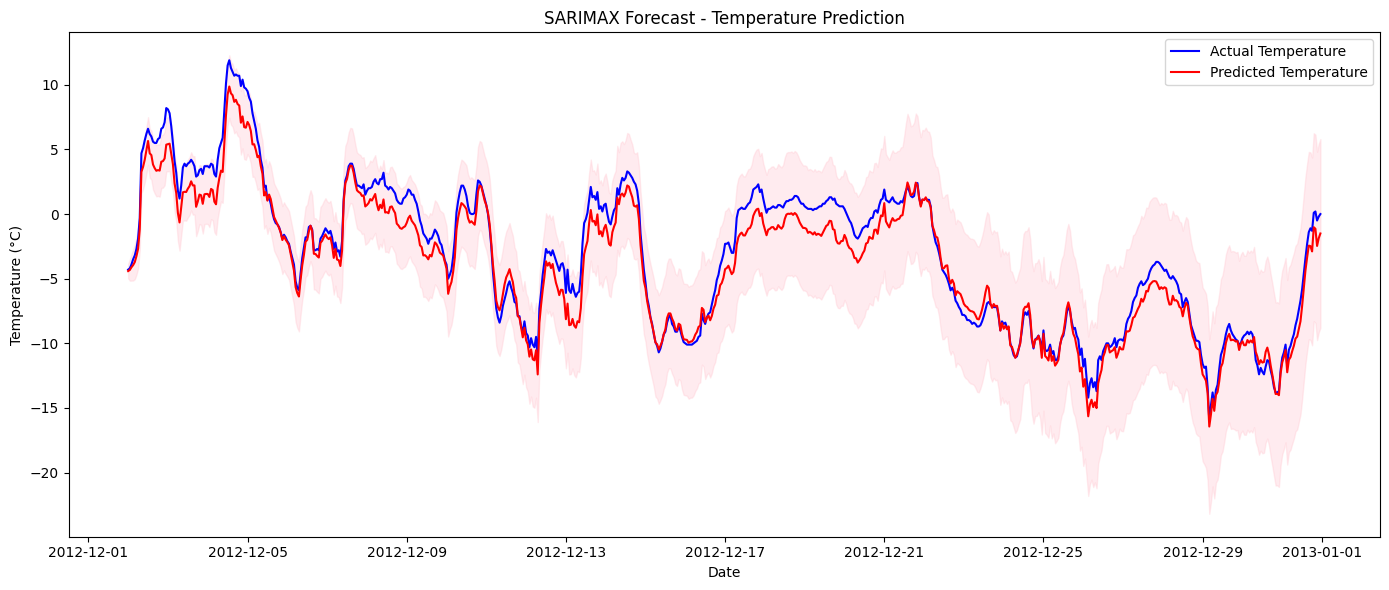

Test RMSE: 1.32 °C


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 1. Load your dataset
df = pd.read_csv('Weather_Data.csv')  # Replace with your file path

# 2. Ensure 'Date/Time' column exists
if 'Date/Time' in df.columns:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
else:
    df['Date/Time'] = pd.date_range(start='2024-01-01', periods=len(df), freq='H')

df.set_index('Date/Time', inplace=True)

# 3. Handle missing values
df.fillna(method='ffill', inplace=True)

# 4. Encode 'Weather' column
le = LabelEncoder()
df['Weather_encoded'] = le.fit_transform(df['Weather'])

# 5. Define target and exogenous variables
target = 'Temp_C'
exog_vars = ['Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h',
             'Visibility_km', 'Press_kPa', 'Weather_encoded']

y = df[target]
exog = df[exog_vars]

# 6. Train/Test Split
# We'll forecast the last 30 days (you can change this)
forecast_horizon = 24 * 30  # 30 days of hourly data
y_train, y_test = y[:-forecast_horizon], y[-forecast_horizon:]
exog_train, exog_test = exog[:-forecast_horizon], exog[-forecast_horizon:]

# 7. Fit SARIMAX model
model = SARIMAX(y_train,
                exog=exog_train,
                order=(2, 1, 2),         # You can tune this
                seasonal_order=(1, 1, 1, 24),  # 24-hour seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# 8. Forecast
pred = results.get_forecast(steps=forecast_horizon, exog=exog_test)
y_pred = pred.predicted_mean
conf_int = pred.conf_int()

# 9. Plot results
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual Temperature', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Temperature', color='red')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast - Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()

# 10. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f} °C")


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 1. Load your dataset
df = pd.read_csv('Weather_Data.csv')  # Replace with your file path

# 2. Ensure 'Date/Time' column exists
if 'Date/Time' in df.columns:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
else:
    df['Date/Time'] = pd.date_range(start='2024-01-01', periods=len(df), freq='H')

df.set_index('Date/Time', inplace=True)

# 3. Handle missing values
df.fillna(method='ffill', inplace=True)

# 4. Encode 'Weather' column
le = LabelEncoder()
df['Weather_encoded'] = le.fit_transform(df['Weather'])

# 5. Define target and exogenous variables
target = 'Temp_C'
exog_vars = ['Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h',
             'Visibility_km', 'Press_kPa', 'Weather_encoded']

y = df[target]
exog = df[exog_vars]

# 6. Train/Test Split
# We'll forecast the last 30 days (you can change this)
forecast_horizon = 24 * 30  # 30 days of hourly data
y_train, y_test = y[:-forecast_horizon], y[-forecast_horizon:]
exog_train, exog_test = exog[:-forecast_horizon], exog[-forecast_horizon:]

# 7. Fit SARIMAX model
model = SARIMAX(y_train,
                exog=exog_train,
                order=(2, 1, 2),         # You can tune this
                seasonal_order=(1, 1, 1, 168),  # 24-hour seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# 8. Forecast
pred = results.get_forecast(steps=forecast_horizon, exog=exog_test)
y_pred = pred.predicted_mean
conf_int = pred.conf_int()

# 9. Plot results
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual Temperature', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Temperature', color='red')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Forecast - Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()

# 10. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f} °C")


KeyboardInterrupt: 